#### Import packages and device selection

In [1]:
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional.image import image_gradients, peak_signal_noise_ratio, structural_similarity_index_measure
from torchmetrics.regression import PearsonCorrCoef
import torchvision
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
SIZE = 160
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

In [5]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

data_color = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    data_color.append(img)
data_color = np.array(data_color)

data_gray = []
path = '../data/gray'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder):
    img = cv2.imread(path + '/' + file, 1)
    img = cv2.resize(img, (SIZE, SIZE))
    data_gray.append(img)
data_gray = np.array(data_gray)

  0%|          | 0/7129 [00:00<?, ?it/s]

  0%|          | 0/7129 [00:00<?, ?it/s]

In [6]:
print(data_color.shape, data_gray.shape)

(7129, 160, 160, 3) (7129, 160, 160, 3)


#### Display some samples

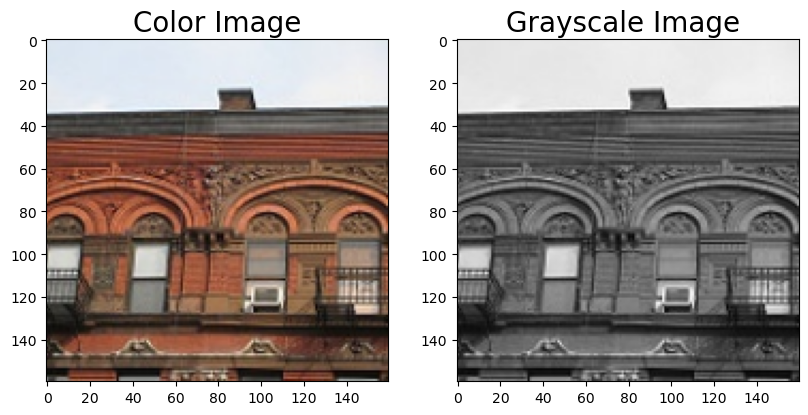

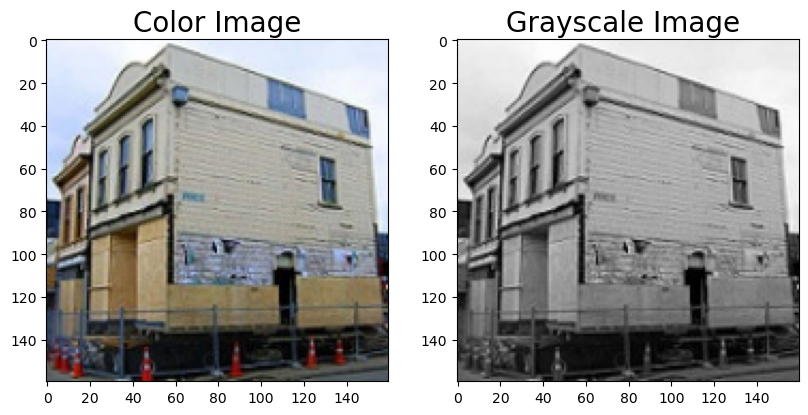

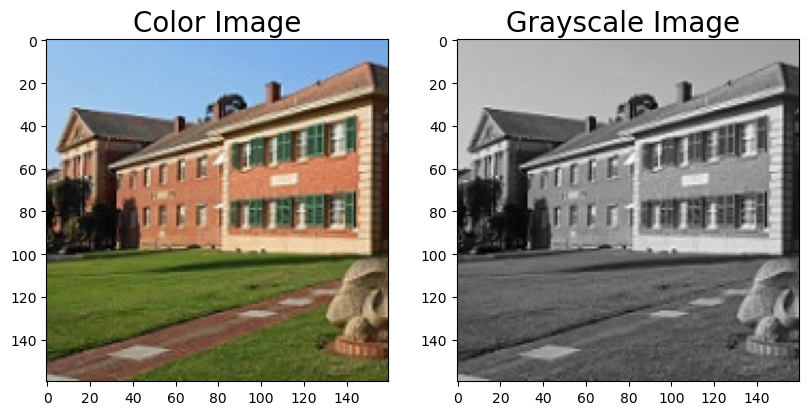

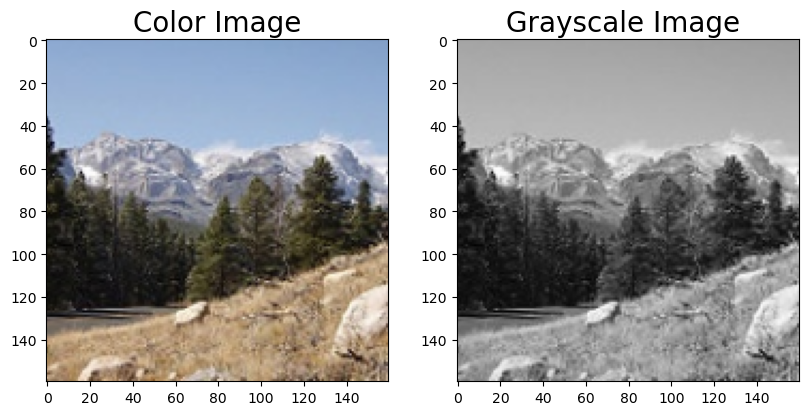

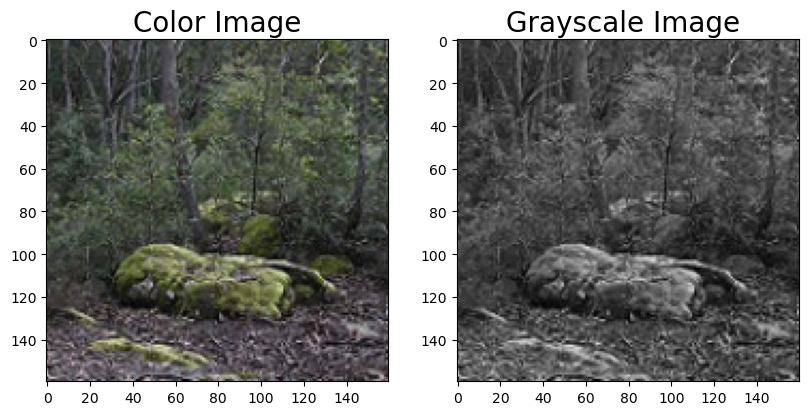

In [7]:
for _ in range(5):
    idx = np.random.randint(0, len(data_color) - 1)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Color Image', fontsize=20)
    plt.imshow(data_color[idx])
    plt.subplot(1, 3, 2)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow(data_gray[idx])
    plt.show()


In [8]:
color_min = np.min(data_color, axis=(0, 1, 2), keepdims=True)
color_max = np.max(data_color, axis=(0, 1, 2), keepdims=True)
gray_min = np.min(data_gray, axis=(0, 1, 2), keepdims=True)
gray_max = np.max(data_gray, axis=(0, 1, 2), keepdims=True)
data_color_scaled = (data_color - color_min) / (color_max - color_min)
data_gray_scaled = (data_gray - gray_min) / (gray_max - gray_min)
color_mean = np.mean(data_color_scaled, axis=(0, 1, 2))
color_std = np.std(data_color_scaled, axis=(0, 1, 2))
gray_mean = np.mean(data_gray_scaled, axis=(0, 1, 2))
gray_std = np.std(data_gray_scaled, axis=(0, 1, 2))

In [9]:
print(color_mean, color_std)
print(gray_mean, gray_std)

[0.4259814  0.45559374 0.44937065] [0.25829469 0.25662458 0.29237895]
[0.44589136 0.44589136 0.44589136] [0.25375797 0.25375797 0.25375797]


In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_gray, data_color, gray_transform=None, color_transform=None):
        self.data_color = data_color
        self.data_gray = data_gray
        self.gray_transform = gray_transform
        self.color_transform = color_transform

    def __len__(self):
        return len(self.data_gray)

    def __getitem__(self, idx):
        gray_img = self.data_gray[idx]
        color_img = self.data_color[idx]
        if self.gray_transform:
            gray_img = self.gray_transform(gray_img)
        if self.color_transform:
            color_img = self.color_transform(color_img)
        return gray_img, color_img

In [11]:
gray_train, gray_test, color_train, color_test = (
    train_test_split(data_gray, data_color, test_size=0.2, random_state=42))

In [12]:
print(len(gray_train), len(gray_test))

5703 1426


## Training pipeline

#### Split into training and test data

In [13]:
gray_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std)
])
color_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std)
])
trainset = MyDataset(gray_train, color_train, gray_transform=gray_transform, color_transform=color_transform)
testset = MyDataset(gray_test, color_test, gray_transform=gray_transform, color_transform=color_transform)
del gray_train, gray_test, color_train, color_test # release memory

#### Early stopping used to stop training if model begins to overfit

In [14]:
class EarlyStopping:
    def __init__(self, patience=15, delta=0.5, window_size=10):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta
        self.window_size = window_size
        self.val_window = []

    def __call__(self, val_loss, net):
        self.val_window.append(val_loss)
        if len(self.val_window) > self.window_size:
            self.val_window.pop(0)
        avg_val = np.mean(self.val_window)

        if avg_val == self.best_score or avg_val > self.best_score + self.delta:
            self.counter += 1
        elif avg_val < self.best_score:
            self.best_score = avg_val
            self.save_checkpoint(net)
            self.counter = 0
        if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), '../models/checkpoint.pth')

#### ImageGradienLoss class and fit/predict methods

$ \_comp.pow(2).sum(dim=1)$ computes $∑𝑐[Δ]^2$ directly, which is algebraically identical to $∥Δ∥_2^2$ but skips the square‐root.

In [25]:
class ImageGradientLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ImageGradientLoss, self).__init__()

    def forward(self, inputs, targets):
        dh_in, dv_in = image_gradients(inputs) # (B, C, H, W-1), (B, C, H-1, W)
        dh_tar, dv_tar = image_gradients(targets)
        dh_comp = (dh_in - dh_tar) ** 2
        dv_comp = (dv_in - dv_tar) ** 2
        return (dh_comp + dv_comp).sum()

def compute_pcc(pred, targets):
    pred_flat = pred.reshape(pred.size(0), -1)
    target_flat = targets.reshape(targets.size(0), -1)
    vx = pred_flat - pred_flat.mean(dim=1, keepdim=True)
    vy = target_flat - target_flat.mean(dim=1, keepdim=True)
    numerator = (vx * vy).sum(dim=1) # covariance
    denominator = torch.sqrt((vx**2).sum(dim=1) * (vy**2).sum(dim=1)) # standard deviation
    return (numerator / denominator).mean()

def fit(net, trainloader, optimizer, loss_fn1=nn.MSELoss(reduction='sum'), loss_fn2=ImageGradientLoss(), coeff=0.5):
    net.train()

    total_loss, total_rmse, total_psnr, total_ssim, total_pcc, count = 0, 0, 0, 0, 0, 0
    for grays, colors in tqdm(trainloader, desc='trainloader', leave=False):
        grays, colors = grays.to(device), colors.to(device)
        optimizer.zero_grad()
        out = net(grays)
        numel = out.numel()
        loss1, loss2 = loss_fn1(out, colors), loss_fn2(out, colors)
        loss = (coeff * loss1 + (1-coeff) * loss2) / numel
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        total_loss += loss.item()
        count += len(colors)
        with torch.no_grad():
            batch_rmse = torch.sqrt(loss1 / numel)
            batch_psnr = (20 * torch.log10(1.0 / batch_rmse))
            total_rmse += batch_rmse.item() * len(colors)
            total_psnr += batch_psnr.item() * len(colors)
            total_ssim += structural_similarity_index_measure(out, colors).item() * len(colors)
            total_pcc += compute_pcc(out, colors).item() * len(colors)
    return total_loss / count, total_rmse / count, total_psnr / count, total_ssim / count, total_pcc / count

def predict(net, testloader, loss_fn1=nn.MSELoss(reduction='sum'), loss_fn2=ImageGradientLoss(), coeff=0.5):
    net.eval()
    total_loss, total_rmse, total_psnr, total_ssim, total_pcc, count = 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for grays, colors in tqdm(testloader, desc='testloader', leave=False):
            grays, colors = grays.to(device), colors.to(device)
            out = net(grays)
            numel = out.numel()
            loss1, loss2 = loss_fn1(out, colors), loss_fn2(out, colors)
            loss = (coeff * loss1 + (1 - coeff) * loss2) / numel
            total_loss += loss.item()
            count += len(colors)
            batch_rmse = torch.sqrt(loss1 / numel)
            batch_psnr = (20 * torch.log10(1.0 / batch_rmse))
            total_rmse += batch_rmse.item() * len(colors)
            total_psnr += batch_psnr.item() * len(colors)
            total_ssim += structural_similarity_index_measure(out, colors).item() * len(colors)
            total_pcc += compute_pcc(out, colors).item() * len(colors)
    return total_loss / count, total_rmse / count, total_psnr / count, total_ssim / count, total_pcc / count

#### Objective method for k fold cross validation

In [16]:
def objective(trial, trainset, X, y):
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64,256, 512, 1024])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0
    train_loss, train_rmse, train_psnr, train_ssim, train_pcc = 0, 0, 0, 0, 0
    val_loss, val_rmse, val_psnr, val_ssim, val_pcc = 0, 0, 0, 0, 0
    split_n = 0
    prog_bar = tqdm(kf.split(X, y), desc="Splits")
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx))
        net = Net().to(device)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)
        early_stopping = EarlyStopping()
        for epoch in range(100):
            train_loss, train_rmse, train_psnr, train_ssim, train_pcc = fit(net, trainloader, optimizer)
            val_loss, val_rmse, val_psnr, val_ssim, val_pcc = predict(net, valloader)
            scheduler.step(val_loss)
            early_stopping(val_loss, net)
            prog_bar.set_description(
                f"Split {split_n} - Epoch {epoch + 1} | lr={current_lr:.3e} | "
                f"Metrics train/val: RMSE={train_rmse:.3e}/{val_rmse:.3e}, "
                f"PSNR={train_psnr:.3e}/{val_psnr:.3e}, SSIM={train_ssim:.3e}/{val_ssim:.3e}, "
                f"PCC={train_pcc:.3e}/{val_pcc:.3e} | Loss: {train_loss:.3e}/{val_loss:.3e}")
            if early_stopping.early_stop:
                break
        val_losses.append(val_loss)
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)
        self.convt1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.convt2 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.convt3 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.convt4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.convt5 = nn.ConvTranspose2d(256, 3, 4, 2, 1)
        self.bnorm1 = nn.BatchNorm2d(256)
        self.bnorm2 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.2)
        self.lrelu = nn.LeakyReLU()
        self.final = nn.Conv2d(6, 3, 1, 1)

    def forward(self, x):
        d1 = self.lrelu(self.conv1(x)) # (B, 128, 80, 80)
        d2 = self.lrelu(self.conv2(d1)) # (B, 128, 40, 40)
        d3 = self.lrelu(self.bnorm1(self.conv3(d2))) # (B, 256, 20, 20)
        d4 = self.lrelu(self.bnorm2(self.conv4(d3))) # (B, 512, 10, 10)
        d5 = self.lrelu(self.bnorm2(self.conv5(d4))) # (B, 512, 5, 5)
        u1 = self.lrelu(self.convt1(d5)) # (B, 512, 10, 10)
        u1 = torch.cat([u1, d4], dim=1) # (B, 1024, 10, 10)
        u2 = self.lrelu(self.convt2(u1)) # (B, 256, 20, 20)
        u2 = torch.cat([u2, d3], dim=1) # (B, 512, 20, 20)
        u3 = self.lrelu(self.convt3(u2)) # (B, 128, 40, 40)
        u3 = torch.cat([u3, d2], dim=1) # (B, 256, 40, 40)
        u4 = self.lrelu(self.convt4(u3)) # (B, 128, 80, 80)
        u4 = torch.cat([u4, d1], dim=1) # (B, 256, 80, 80)
        u5 = self.lrelu(self.convt5(u4)) # (B, 3, 160, 160)
        u5 = torch.cat([u5, x], dim=1) # (B, 6, 160, 160)
        x = self.final(u5) # (B, 3, 160, 160)
        return x

In [18]:
writer = SummaryWriter('../runs')
net = Net().to(device)
writer.add_graph(net, torch.zeros(1, 3, SIZE, SIZE).to(device))
writer.flush()
summary(net, input_size=(1, 3, SIZE, SIZE), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 3, 160, 160]          --
├─Conv2d: 1-1                            [1, 128, 80, 80]          6,272
├─LeakyReLU: 1-2                         [1, 128, 80, 80]          --
├─Conv2d: 1-3                            [1, 128, 40, 40]          262,272
├─LeakyReLU: 1-4                         [1, 128, 40, 40]          --
├─Conv2d: 1-5                            [1, 256, 20, 20]          524,544
├─BatchNorm2d: 1-6                       [1, 256, 20, 20]          512
├─LeakyReLU: 1-7                         [1, 256, 20, 20]          --
├─Conv2d: 1-8                            [1, 512, 10, 10]          2,097,664
├─BatchNorm2d: 1-9                       [1, 512, 10, 10]          1,024
├─LeakyReLU: 1-10                        [1, 512, 10, 10]          --
├─Conv2d: 1-11                           [1, 512, 5, 5]            4,194,816
├─BatchNorm2d: 1-12                      [1, 512, 5, 5

#### Hyper parameter tuning

In [ ]:
X = np.zeros(len(trainset))
labelloader =  DataLoader(trainset, batch_size=256, shuffle=False)
y = []
for _, label in labelloader:
    y.append(label.numpy())
y = np.concatenate(y, axis=0)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, X, y), n_trials=10)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Entire dataset

In [23]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
early_stopping = EarlyStopping()
train_RMSEs, train_PSNRs, train_SSIMs, train_PCCs, train_losses = [], [], [], [], []
test_RMSEs, test_PSNRs, test_SSIMs, test_PCCs, test_losses = [], [], [], [], []
prog_bar = tqdm(range(10), total=100, desc='Training')
torch.cuda.empty_cache()
for epoch in prog_bar:
    train_loss, train_RMSE, train_PSNR, train_SSIM, train_PCC = fit(net, trainloader, optimizer)
    train_losses.append(train_loss)
    train_RMSEs.append(train_RMSE)
    train_PSNRs.append(train_PSNR)
    train_SSIMs.append(train_SSIM)
    train_PCCs.append(train_PCC)
    test_loss, test_RMSE, test_PSNR, test_SSIM, test_PCC = predict(net, testloader)
    test_losses.append(test_loss)
    test_RMSEs.append(test_RMSE)
    test_PSNRs.append(test_PSNR)
    test_SSIMs.append(test_SSIM)
    test_PCCs.append(test_PCC)
    #sheduler.step(test_loss)
    #early_stopping(test_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1} | lr={current_lr:.3e} | "
                             f"Metrics train/test: RMSE={train_RMSE:.3e}/{test_RMSE:.3e}, "
                             f"PSNR={train_PSNR:.3e}/{test_PSNR:.3e}, SSIM={train_SSIM:.3e}/{test_SSIM:.3e}, "
                             f"PCC={train_PCC:.3e}/{test_PCC:.3e} | Loss: {train_loss:.3e}/{test_loss:.3e}")
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break

Training:   0%|          | 0/100 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

trainloader:   0%|          | 0/23 [00:00<?, ?it/s]

testloader:   0%|          | 0/6 [00:00<?, ?it/s]

## Evaluate results

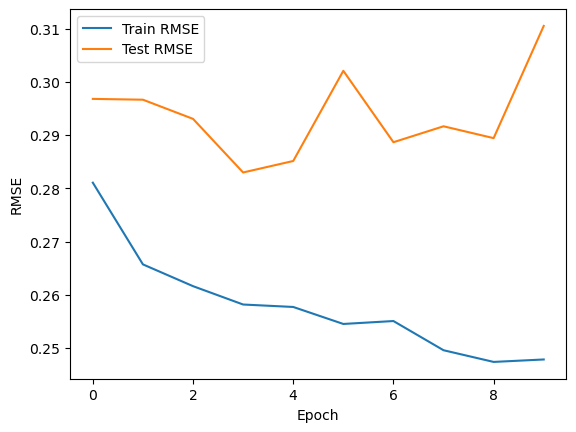

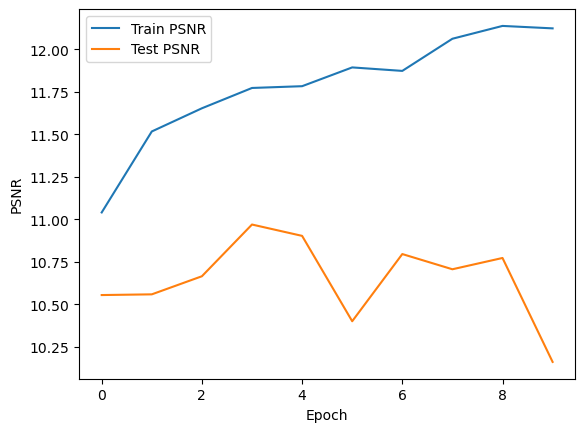

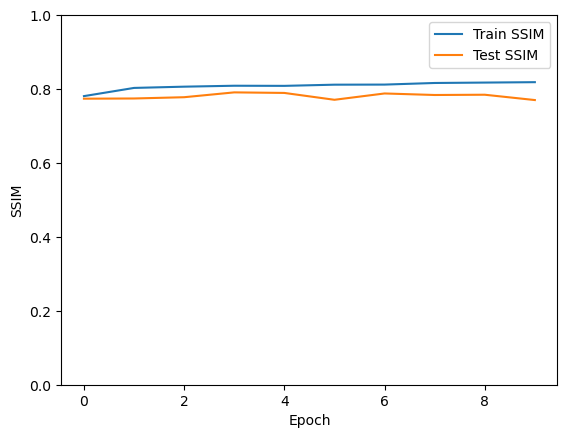

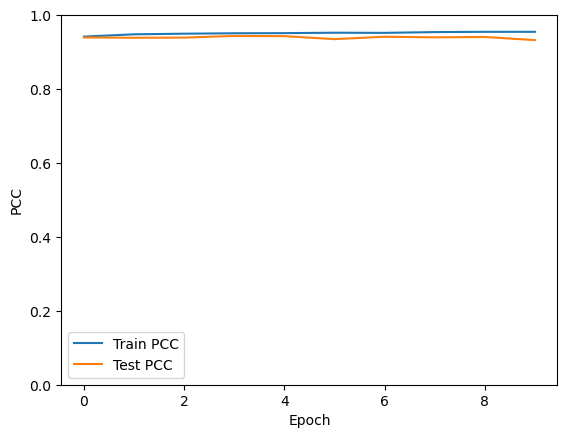

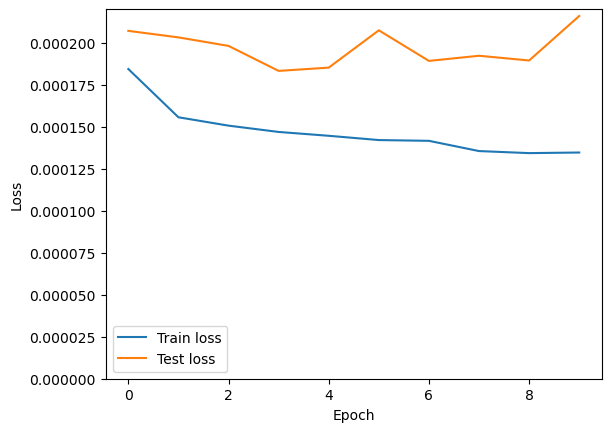

In [24]:
plt.figure()
plt.plot(train_RMSEs, label='Train RMSE')
plt.plot(test_RMSEs, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_PSNRs, label='Train PSNR')
plt.plot(test_PSNRs, label='Test PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_SSIMs, label='Train SSIM')
plt.plot(test_SSIMs, label='Test SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_PCCs, label='Train PCC')
plt.plot(test_PCCs, label='Test PCC')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()